### GCN

In [18]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_scipy_sparse_matrix
import scipy.sparse as sp
import json

# =========================
# 1. Load and Preprocess Data
# =========================

# Load adjacency matrix, features, labels, and splits
adj = sp.load_npz('data/data/adj.npz')
feat = np.load('data/data/features.npy')
labels = np.load('data/data/labels.npy')
splits = json.load(open('data/data/splits.json'))
idx_train, idx_test = splits['idx_train'], splits['idx_test']

# Convert to PyTorch tensors
x = torch.from_numpy(feat).float()
edge_index, _ = from_scipy_sparse_matrix(adj)

# Initialize all labels as -1 and set only train labels
y = torch.full((x.shape[0],), -1, dtype=torch.long)
y[idx_train] = torch.from_numpy(labels).long()

# Convert indices to tensors
idx_train = torch.tensor(idx_train, dtype=torch.long)
idx_test = torch.tensor(idx_test, dtype=torch.long)

# Filter training indices to only valid labels
idx_train = idx_train[y[idx_train] != -1]

# =========================
# 2. Define GCN Model
# =========================

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# =========================
# 3. Training Setup
# =========================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x, edge_index, y = x.to(device), edge_index.to(device), y.to(device)
idx_train = idx_train.to(device)
idx_test = idx_test.to(device)

num_features = x.shape[1]
num_classes = y[idx_train].max().item() + 1  # number of classes in train

model = GCN(num_features, hidden_dim=64, num_classes=num_classes, dropout=0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# =========================
# 4. Training Loop
# =========================

best_acc = 0
best_pred = None

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index)
    loss = criterion(out[idx_train], y[idx_train])
    loss.backward()
    optimizer.step()

    # Evaluate on train set
    model.eval()
    _, pred = out.max(dim=1)
    correct = int((pred[idx_train] == y[idx_train]).sum())
    acc = correct / len(idx_train)

    if acc > best_acc:
        best_acc = acc
        best_pred = pred.detach().cpu().numpy()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f} | Train Acc: {acc*100:.2f}%")

# =========================
# 5. Predict and Save Results
# =========================

model.eval()
with torch.no_grad():
    out = model(x, edge_index)
    pred = out.argmax(dim=1).cpu().numpy()


# Save in current working directory
output_dir = ''  
output_path = os.path.join(output_dir, 'your_team_submission_GCN.txt')

# Save the file
np.savetxt(output_path, submission, fmt='%d %d')

# Confirm and preview results
print(f"Submission saved to: {os.path.abspath(output_path)}")
with open(output_path, 'r') as f:
    for _ in range(10):
        print(f.readline().strip())


Epoch 0 | Loss: 1.9456 | Train Acc: 16.53%
Epoch 10 | Loss: 0.2910 | Train Acc: 93.35%
Epoch 20 | Loss: 0.0755 | Train Acc: 98.59%
Epoch 30 | Loss: 0.0477 | Train Acc: 99.19%
Epoch 40 | Loss: 0.0404 | Train Acc: 99.19%
Epoch 50 | Loss: 0.0360 | Train Acc: 99.80%
Epoch 60 | Loss: 0.0449 | Train Acc: 99.60%
Epoch 70 | Loss: 0.0396 | Train Acc: 99.40%
Epoch 80 | Loss: 0.0340 | Train Acc: 100.00%
Epoch 90 | Loss: 0.0311 | Train Acc: 99.80%
Epoch 100 | Loss: 0.0318 | Train Acc: 100.00%
Epoch 110 | Loss: 0.0306 | Train Acc: 100.00%
Epoch 120 | Loss: 0.0288 | Train Acc: 99.80%
Epoch 130 | Loss: 0.0322 | Train Acc: 99.60%
Epoch 140 | Loss: 0.0270 | Train Acc: 100.00%
Epoch 150 | Loss: 0.0279 | Train Acc: 99.80%
Epoch 160 | Loss: 0.0284 | Train Acc: 99.80%
Epoch 170 | Loss: 0.0271 | Train Acc: 99.60%
Epoch 180 | Loss: 0.0247 | Train Acc: 99.80%
Epoch 190 | Loss: 0.0216 | Train Acc: 100.00%
Submission saved to: E:\Data_Mining\your_team_submission_GCN.txt
2051 6
1788 3
1233 0
926 5
2053 1
2083 3


### GraphSage

In [15]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import from_scipy_sparse_matrix
import scipy.sparse as sp
import json

# =========================
# 1. Load and Preprocess Data
# =========================

# Load adjacency matrix, features, labels, and splits
adj = sp.load_npz('data/data/adj.npz')
feat = np.load('data/data/features.npy')
labels = np.load('data/data/labels.npy')
splits = json.load(open('data/data/splits.json'))
idx_train, idx_test = splits['idx_train'], splits['idx_test']

# Convert to PyTorch tensors
x = torch.from_numpy(feat).float()
edge_index, _ = from_scipy_sparse_matrix(adj)

# Initialize all labels as -1 and assign labels for training nodes
y = torch.full((x.shape[0],), -1, dtype=torch.long)
y[idx_train] = torch.from_numpy(labels).long()

# Convert indices to tensors
idx_train = torch.tensor(idx_train, dtype=torch.long)
idx_test = torch.tensor(idx_test, dtype=torch.long)

# Filter invalid label indices
idx_train = idx_train[y[idx_train] != -1]

# =========================
# 2. Define GraphSAGE Model
# =========================

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# =========================
# 3. Training Setup
# =========================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x, edge_index, y = x.to(device), edge_index.to(device), y.to(device)
idx_train = idx_train.to(device)
idx_test = idx_test.to(device)

num_features = x.shape[1]
num_classes = y[idx_train].max().item() + 1

model = GraphSAGE(num_features, hidden_channels=64, out_channels=num_classes, dropout=0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# =========================
# 4. Training Loop
# =========================

best_acc = 0
best_pred = None

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index)
    loss = criterion(out[idx_train], y[idx_train])
    loss.backward()
    optimizer.step()

    # Train accuracy
    model.eval()
    _, pred = out.max(dim=1)
    correct = int((pred[idx_train] == y[idx_train]).sum())
    acc = correct / len(idx_train)

    if acc > best_acc:
        best_acc = acc
        best_pred = pred.detach().cpu().numpy()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f} | Train Acc: {acc*100:.2f}%")

# =========================
# 5. Predict and Save Results
# =========================

model.eval()
with torch.no_grad():
    out = model(x, edge_index)
    pred = out.argmax(dim=1).cpu().numpy()

# Prepare submission
# Save in current working directory
output_dir = ''  # leave empty to save in current script directory
output_path = os.path.join(output_dir, 'your_team_submission_sage.txt')

# Save the file
np.savetxt(output_path, submission, fmt='%d %d')

# Confirm and preview results
print(f"Submission saved to: {os.path.abspath(output_path)}")
with open(output_path, 'r') as f:
    for _ in range(10):
        print(f.readline().strip())



Epoch 0 | Loss: 1.9266 | Train Acc: 27.82%
Epoch 10 | Loss: 0.0900 | Train Acc: 97.38%
Epoch 20 | Loss: 0.0064 | Train Acc: 100.00%
Epoch 30 | Loss: 0.0046 | Train Acc: 99.80%
Epoch 40 | Loss: 0.0060 | Train Acc: 100.00%
Epoch 50 | Loss: 0.0081 | Train Acc: 100.00%
Epoch 60 | Loss: 0.0106 | Train Acc: 100.00%
Epoch 70 | Loss: 0.0132 | Train Acc: 100.00%
Epoch 80 | Loss: 0.0111 | Train Acc: 100.00%
Epoch 90 | Loss: 0.0101 | Train Acc: 100.00%
Epoch 100 | Loss: 0.0133 | Train Acc: 100.00%
Epoch 110 | Loss: 0.0104 | Train Acc: 100.00%
Epoch 120 | Loss: 0.0079 | Train Acc: 100.00%
Epoch 130 | Loss: 0.0093 | Train Acc: 100.00%
Epoch 140 | Loss: 0.0101 | Train Acc: 100.00%
Epoch 150 | Loss: 0.0079 | Train Acc: 100.00%
Epoch 160 | Loss: 0.0094 | Train Acc: 100.00%
Epoch 170 | Loss: 0.0069 | Train Acc: 100.00%
Epoch 180 | Loss: 0.0080 | Train Acc: 100.00%
Epoch 190 | Loss: 0.0072 | Train Acc: 100.00%
Submission saved to: E:\Data_Mining\your_team_submission_sage.txt
2051 6
1788 3
1233 0
926 5
2

### GAT

In [16]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.utils import from_scipy_sparse_matrix
import scipy.sparse as sp
import json

# =========================
# 1. Load and Preprocess Data
# =========================

# Load adjacency matrix, features, labels, and splits
adj = sp.load_npz('data/data/adj.npz')
feat = np.load('data/data/features.npy')
labels = np.load('data/data/labels.npy')
splits = json.load(open('data/data/splits.json'))
idx_train, idx_test = splits['idx_train'], splits['idx_test']

# Convert to PyTorch tensors
x = torch.from_numpy(feat).float()
edge_index, _ = from_scipy_sparse_matrix(adj)

# Initialize label tensor with -1
y = torch.full((x.shape[0],), -1, dtype=torch.long)
y[idx_train] = torch.from_numpy(labels).long()

# Convert index arrays to torch tensors
idx_train = torch.tensor(idx_train, dtype=torch.long)
idx_test = torch.tensor(idx_test, dtype=torch.long)

# Remove any invalid label indices from training set
idx_train = idx_train[y[idx_train] != -1]

# =========================
# 2. Define GAT Model
# =========================

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.6):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat2(x, edge_index)
        return x

# =========================
# 3. Training Setup
# =========================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x, edge_index, y = x.to(device), edge_index.to(device), y.to(device)
idx_train = idx_train.to(device)
idx_test = idx_test.to(device)

num_features = x.shape[1]
num_classes = y[idx_train].max().item() + 1

model = GAT(num_features, hidden_channels=8, out_channels=num_classes, heads=8, dropout=0.6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# =========================
# 4. Training Loop
# =========================

best_acc = 0
best_pred = None

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index)
    loss = criterion(out[idx_train], y[idx_train])
    loss.backward()
    optimizer.step()

    # Evaluate on train set
    model.eval()
    _, pred = out.max(dim=1)
    correct = int((pred[idx_train] == y[idx_train]).sum())
    acc = correct / len(idx_train)

    if acc > best_acc:
        best_acc = acc
        best_pred = pred.detach().cpu().numpy()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f} | Train Acc: {acc*100:.2f}%")

# =========================
# 5. Predict and Save Results
# =========================

model.eval()
with torch.no_grad():
    out = model(x, edge_index)
    pred = out.argmax(dim=1).cpu().numpy()

# Prepare submission
output_dir = ''  # leave empty to save in current script directory
output_path = os.path.join(output_dir, 'your_team_submission_gat.txt')

# Save the file
np.savetxt(output_path, submission, fmt='%d %d')

# Confirm and preview results
print(f"Submission saved to: {os.path.abspath(output_path)}")
with open(output_path, 'r') as f:
    for _ in range(10):
        print(f.readline().strip())


Epoch 0 | Loss: 1.9975 | Train Acc: 15.52%
Epoch 10 | Loss: 1.1594 | Train Acc: 69.56%
Epoch 20 | Loss: 0.8810 | Train Acc: 77.42%
Epoch 30 | Loss: 0.7279 | Train Acc: 77.62%
Epoch 40 | Loss: 0.6735 | Train Acc: 78.23%
Epoch 50 | Loss: 0.6071 | Train Acc: 80.44%
Epoch 60 | Loss: 0.6539 | Train Acc: 79.84%
Epoch 70 | Loss: 0.6094 | Train Acc: 83.27%
Epoch 80 | Loss: 0.5884 | Train Acc: 81.25%
Epoch 90 | Loss: 0.5487 | Train Acc: 81.85%
Epoch 100 | Loss: 0.5980 | Train Acc: 80.04%
Epoch 110 | Loss: 0.6034 | Train Acc: 80.04%
Epoch 120 | Loss: 0.5743 | Train Acc: 81.85%
Epoch 130 | Loss: 0.5121 | Train Acc: 84.27%
Epoch 140 | Loss: 0.4923 | Train Acc: 82.66%
Epoch 150 | Loss: 0.5141 | Train Acc: 82.86%
Epoch 160 | Loss: 0.5359 | Train Acc: 82.06%
Epoch 170 | Loss: 0.5571 | Train Acc: 80.65%
Epoch 180 | Loss: 0.5273 | Train Acc: 82.86%
Epoch 190 | Loss: 0.5612 | Train Acc: 81.25%
Submission saved to: E:\Data_Mining\your_team_submission_gat.txt
2051 6
1788 3
1233 0
926 5
2053 1
2083 3
2370 

### Baseline MLP

In [17]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.utils import from_scipy_sparse_matrix
import scipy.sparse as sp
import json

# =========================
# 1. Load and Preprocess Data
# =========================

# Load adjacency matrix, features, labels, and splits
adj = sp.load_npz('data/data/adj.npz')
feat = np.load('data/data/features.npy')
labels = np.load('data/data/labels.npy')
splits = json.load(open('data/data/splits.json'))
idx_train, idx_test = splits['idx_train'], splits['idx_test']

# Convert features to torch tensor
x = torch.from_numpy(feat).float()

# Initialize label tensor with -1
y = torch.full((x.shape[0],), -1, dtype=torch.long)
y[idx_train] = torch.from_numpy(labels).long()

# Convert index arrays to torch tensors
idx_train = torch.tensor(idx_train, dtype=torch.long)
idx_test = torch.tensor(idx_test, dtype=torch.long)

# Remove invalid label indices from training set
idx_train = idx_train[y[idx_train] != -1]

# =========================
# 2. Define MLP Model
# =========================

class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_channels, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc2(x)
        return x

# =========================
# 3. Training Setup
# =========================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x, y = x.to(device), y.to(device)
idx_train = idx_train.to(device)
idx_test = idx_test.to(device)

num_features = x.shape[1]
num_classes = y[idx_train].max().item() + 1

model = MLP(num_features, hidden_channels=64, out_channels=num_classes, dropout=0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# =========================
# 4. Training Loop
# =========================

best_acc = 0
best_pred = None

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(x)
    loss = criterion(out[idx_train], y[idx_train])
    loss.backward()
    optimizer.step()

    # Evaluate on train set
    model.eval()
    _, pred = out.max(dim=1)
    correct = int((pred[idx_train] == y[idx_train]).sum())
    acc = correct / len(idx_train)

    if acc > best_acc:
        best_acc = acc
        best_pred = pred.detach().cpu().numpy()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f} | Train Acc: {acc*100:.2f}%")

# =========================
# 5. Predict and Save Results
# =========================

model.eval()
with torch.no_grad():
    out = model(x)
    pred = out.argmax(dim=1).cpu().numpy()

# Prepare submission
output_dir = ''  # leave empty to save in current script directory
output_path = os.path.join(output_dir, 'your_team_submission_mlp.txt')

# Save the file
np.savetxt(output_path, submission, fmt='%d %d')

# Confirm and preview results
print(f"Submission saved to: {os.path.abspath(output_path)}")
with open(output_path, 'r') as f:
    for _ in range(10):
        print(f.readline().strip())


Epoch 0 | Loss: 1.9420 | Train Acc: 16.53%
Epoch 10 | Loss: 0.4451 | Train Acc: 93.15%
Epoch 20 | Loss: 0.0798 | Train Acc: 98.59%
Epoch 30 | Loss: 0.0367 | Train Acc: 99.19%
Epoch 40 | Loss: 0.0248 | Train Acc: 99.60%
Epoch 50 | Loss: 0.0272 | Train Acc: 99.40%
Epoch 60 | Loss: 0.0261 | Train Acc: 100.00%
Epoch 70 | Loss: 0.0252 | Train Acc: 100.00%
Epoch 80 | Loss: 0.0282 | Train Acc: 99.80%
Epoch 90 | Loss: 0.0293 | Train Acc: 99.60%
Epoch 100 | Loss: 0.0243 | Train Acc: 100.00%
Epoch 110 | Loss: 0.0183 | Train Acc: 99.80%
Epoch 120 | Loss: 0.0225 | Train Acc: 100.00%
Epoch 130 | Loss: 0.0191 | Train Acc: 100.00%
Epoch 140 | Loss: 0.0193 | Train Acc: 99.80%
Epoch 150 | Loss: 0.0185 | Train Acc: 100.00%
Epoch 160 | Loss: 0.0277 | Train Acc: 100.00%
Epoch 170 | Loss: 0.0161 | Train Acc: 100.00%
Epoch 180 | Loss: 0.0170 | Train Acc: 100.00%
Epoch 190 | Loss: 0.0176 | Train Acc: 100.00%
Submission saved to: E:\Data_Mining\your_team_submission_mlp.txt
2051 6
1788 3
1233 0
926 5
2053 1
20

### MLP 

In [20]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.utils import from_scipy_sparse_matrix
import scipy.sparse as sp
import json
from sklearn.model_selection import train_test_split

# =========================
# 1. Load and Preprocess Data
# =========================

# Load adjacency matrix, features, labels, and splits
adj = sp.load_npz('data/data/adj.npz')
feat = np.load('data/data/features.npy')
labels = np.load('data/data/labels.npy')
splits = json.load(open('data/data/splits.json'))
idx_train, idx_test = splits['idx_train'], splits['idx_test']

# Convert features to torch tensor
x = torch.from_numpy(feat).float()

# Initialize label tensor with -1 and assign only training labels
y = torch.full((x.shape[0],), -1, dtype=torch.long)
y[idx_train] = torch.from_numpy(labels).long()

# Convert index arrays to torch tensors
idx_train = torch.tensor(idx_train, dtype=torch.long)
idx_test = torch.tensor(idx_test, dtype=torch.long)

# Remove invalid label indices from training set
idx_train = idx_train[y[idx_train] != -1]

# =========================
# 2. Define MLP Model
# =========================

class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_channels, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc2(x)
        return x

# =========================
# 3. Training Setup with 80/20 Split
# =========================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x, y = x.to(device), y.to(device)

# 80/20 split on training indices
train_idx, val_idx = train_test_split(idx_train.cpu().numpy(), test_size=0.2, random_state=42, shuffle=True)
train_idx = torch.tensor(train_idx, dtype=torch.long, device=device)
val_idx = torch.tensor(val_idx, dtype=torch.long, device=device)

idx_test = idx_test.to(device)

num_features = x.shape[1]
num_classes = y[train_idx].max().item() + 1

model = MLP(num_features, hidden_channels=64, out_channels=num_classes, dropout=0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# =========================
# 4. Training Loop with Validation
# =========================

best_val_acc = 0
best_pred = None

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(x)
    loss = criterion(out[train_idx], y[train_idx])
    loss.backward()
    optimizer.step()

    # Evaluate on validation set
    model.eval()
    _, pred = out.max(dim=1)
    val_correct = int((pred[val_idx] == y[val_idx]).sum())
    val_acc = val_correct / len(val_idx)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_pred = pred.detach().cpu().numpy()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f} | Val Acc: {val_acc*100:.2f}%")

# =========================
# 5. Predict and Save Results
# =========================

model.eval()
with torch.no_grad():
    out = model(x)
    pred = out.argmax(dim=1).cpu().numpy()

# Prepare submission
test_node_ids = idx_test.cpu().numpy()
submission = np.stack([test_node_ids, pred[test_node_ids]], axis=1)

output_dir = ''
output_path = os.path.join(output_dir, 'your_team_submission_mlp.txt')
np.savetxt(output_path, submission, fmt='%d %d')

# Confirm and preview results
print(f"Submission saved to: {os.path.abspath(output_path)}")
with open(output_path, 'r') as f:
    for _ in range(10):
        print(f.readline().strip())


Epoch 0 | Loss: 1.9519 | Val Acc: 6.00%
Epoch 10 | Loss: 0.4124 | Val Acc: 67.00%
Epoch 20 | Loss: 0.0759 | Val Acc: 65.00%
Epoch 30 | Loss: 0.0304 | Val Acc: 64.00%
Epoch 40 | Loss: 0.0249 | Val Acc: 62.00%
Epoch 50 | Loss: 0.0201 | Val Acc: 63.00%
Epoch 60 | Loss: 0.0241 | Val Acc: 64.00%
Epoch 70 | Loss: 0.0227 | Val Acc: 70.00%
Epoch 80 | Loss: 0.0189 | Val Acc: 67.00%
Epoch 90 | Loss: 0.0213 | Val Acc: 67.00%
Epoch 100 | Loss: 0.0227 | Val Acc: 66.00%
Epoch 110 | Loss: 0.0173 | Val Acc: 71.00%
Epoch 120 | Loss: 0.0192 | Val Acc: 68.00%
Epoch 130 | Loss: 0.0179 | Val Acc: 65.00%
Epoch 140 | Loss: 0.0166 | Val Acc: 67.00%
Epoch 150 | Loss: 0.0228 | Val Acc: 69.00%
Epoch 160 | Loss: 0.0173 | Val Acc: 71.00%
Epoch 170 | Loss: 0.0166 | Val Acc: 65.00%
Epoch 180 | Loss: 0.0191 | Val Acc: 69.00%
Epoch 190 | Loss: 0.0161 | Val Acc: 64.00%
Submission saved to: E:\Data_Mining\your_team_submission_mlp.txt
2051 6
1788 3
1233 0
926 5
2053 1
2083 3
2370 2
1306 0
1354 6
603 4


### GCN

In [21]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_scipy_sparse_matrix
import scipy.sparse as sp
import json
from sklearn.model_selection import train_test_split

# =========================
# 1. Load and Preprocess Data
# =========================

# Load adjacency matrix, features, labels, and splits
adj = sp.load_npz('data/data/adj.npz')
feat = np.load('data/data/features.npy')
labels = np.load('data/data/labels.npy')
splits = json.load(open('data/data/splits.json'))
idx_train, idx_test = splits['idx_train'], splits['idx_test']

# Convert to PyTorch tensors
x = torch.from_numpy(feat).float()
edge_index, _ = from_scipy_sparse_matrix(adj)

# Initialize label tensor with -1 and assign only training labels
y = torch.full((x.shape[0],), -1, dtype=torch.long)
y[idx_train] = torch.from_numpy(labels).long()

# Convert index arrays to torch tensors
idx_train = torch.tensor(idx_train, dtype=torch.long)
idx_test = torch.tensor(idx_test, dtype=torch.long)

# Filter out unlabeled training indices
idx_train = idx_train[y[idx_train] != -1]

# =========================
# 2. Define GCN Model
# =========================

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# =========================
# 3. Training Setup with 80/20 Split
# =========================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x, y, edge_index = x.to(device), y.to(device), edge_index.to(device)

# Split train/val
train_idx, val_idx = train_test_split(idx_train.cpu().numpy(), test_size=0.2, random_state=42, shuffle=True)
train_idx = torch.tensor(train_idx, dtype=torch.long, device=device)
val_idx = torch.tensor(val_idx, dtype=torch.long, device=device)

idx_test = idx_test.to(device)

num_features = x.shape[1]
num_classes = y[train_idx].max().item() + 1

model = GCN(num_features, hidden_channels=64, out_channels=num_classes, dropout=0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# =========================
# 4. Training Loop with Validation
# =========================

best_val_acc = 0
best_pred = None

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index)
    loss = criterion(out[train_idx], y[train_idx])
    loss.backward()
    optimizer.step()

    # Evaluate on validation set
    model.eval()
    _, pred = out.max(dim=1)
    val_correct = int((pred[val_idx] == y[val_idx]).sum())
    val_acc = val_correct / len(val_idx)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_pred = pred.detach().cpu().numpy()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f} | Val Acc: {val_acc*100:.2f}%")

# =========================
# 5. Predict and Save Results
# =========================

model.eval()
with torch.no_grad():
    out = model(x, edge_index)
    pred = out.argmax(dim=1).cpu().numpy()

# Prepare submission
test_node_ids = idx_test.cpu().numpy()
submission = np.stack([test_node_ids, pred[test_node_ids]], axis=1)

output_dir = ''
output_path = os.path.join(output_dir, 'your_team_submission_gcn.txt')
np.savetxt(output_path, submission, fmt='%d %d')

# Confirm and preview results
print(f"Submission saved to: {os.path.abspath(output_path)}")
with open(output_path, 'r') as f:
    for _ in range(10):
        print(f.readline().strip())


Epoch 0 | Loss: 1.9323 | Val Acc: 23.00%
Epoch 10 | Loss: 0.2824 | Val Acc: 85.00%
Epoch 20 | Loss: 0.0645 | Val Acc: 84.00%
Epoch 30 | Loss: 0.0329 | Val Acc: 83.00%
Epoch 40 | Loss: 0.0286 | Val Acc: 83.00%
Epoch 50 | Loss: 0.0335 | Val Acc: 86.00%
Epoch 60 | Loss: 0.0381 | Val Acc: 85.00%
Epoch 70 | Loss: 0.0274 | Val Acc: 86.00%
Epoch 80 | Loss: 0.0281 | Val Acc: 84.00%
Epoch 90 | Loss: 0.0245 | Val Acc: 86.00%
Epoch 100 | Loss: 0.0254 | Val Acc: 84.00%
Epoch 110 | Loss: 0.0275 | Val Acc: 83.00%
Epoch 120 | Loss: 0.0245 | Val Acc: 85.00%
Epoch 130 | Loss: 0.0234 | Val Acc: 85.00%
Epoch 140 | Loss: 0.0216 | Val Acc: 86.00%
Epoch 150 | Loss: 0.0181 | Val Acc: 87.00%
Epoch 160 | Loss: 0.0220 | Val Acc: 85.00%
Epoch 170 | Loss: 0.0200 | Val Acc: 85.00%
Epoch 180 | Loss: 0.0203 | Val Acc: 84.00%
Epoch 190 | Loss: 0.0212 | Val Acc: 88.00%
Submission saved to: E:\Data_Mining\your_team_submission_gcn.txt
2051 2
1788 3
1233 0
926 5
2053 1
2083 3
2370 6
1306 0
1354 6
603 2


In [22]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import from_scipy_sparse_matrix
import scipy.sparse as sp
import json
from sklearn.model_selection import train_test_split

# =========================
# 1. Load and Preprocess Data
# =========================

# Load adjacency matrix, features, labels, and splits
adj = sp.load_npz('data/data/adj.npz')
feat = np.load('data/data/features.npy')
labels = np.load('data/data/labels.npy')
splits = json.load(open('data/data/splits.json'))
idx_train, idx_test = splits['idx_train'], splits['idx_test']

# Convert to PyTorch tensors
x = torch.from_numpy(feat).float()
edge_index, _ = from_scipy_sparse_matrix(adj)

# Initialize label tensor with -1 and assign training labels
y = torch.full((x.shape[0],), -1, dtype=torch.long)
y[idx_train] = torch.from_numpy(labels).long()

# Convert index arrays to torch tensors
idx_train = torch.tensor(idx_train, dtype=torch.long)
idx_test = torch.tensor(idx_test, dtype=torch.long)

# Filter out invalid indices (where label == -1)
idx_train = idx_train[y[idx_train] != -1]

# =========================
# 2. Define GraphSAGE Model
# =========================

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# =========================
# 3. Training Setup with 80/20 Split
# =========================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x, y, edge_index = x.to(device), y.to(device), edge_index.to(device)

# 80/20 split on labeled training nodes
train_idx, val_idx = train_test_split(idx_train.cpu().numpy(), test_size=0.2, random_state=42, shuffle=True)
train_idx = torch.tensor(train_idx, dtype=torch.long, device=device)
val_idx = torch.tensor(val_idx, dtype=torch.long, device=device)

idx_test = idx_test.to(device)

num_features = x.shape[1]
num_classes = y[train_idx].max().item() + 1

model = GraphSAGE(num_features, hidden_channels=64, out_channels=num_classes, dropout=0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# =========================
# 4. Training Loop with Validation
# =========================

best_val_acc = 0
best_pred = None

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index)
    loss = criterion(out[train_idx], y[train_idx])
    loss.backward()
    optimizer.step()

    # Evaluate on validation set
    model.eval()
    _, pred = out.max(dim=1)
    val_correct = int((pred[val_idx] == y[val_idx]).sum())
    val_acc = val_correct / len(val_idx)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_pred = pred.detach().cpu().numpy()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f} | Val Acc: {val_acc*100:.2f}%")

# =========================
# 5. Predict and Save Results
# =========================

model.eval()
with torch.no_grad():
    out = model(x, edge_index)
    pred = out.argmax(dim=1).cpu().numpy()

# Prepare submission
test_node_ids = idx_test.cpu().numpy()
submission = np.stack([test_node_ids, pred[test_node_ids]], axis=1)

output_dir = ''
output_path = os.path.join(output_dir, 'your_team_submission_sage.txt')
np.savetxt(output_path, submission, fmt='%d %d')

# Confirm and preview results
print(f"Submission saved to: {os.path.abspath(output_path)}")
with open(output_path, 'r') as f:
    for _ in range(10):
        print(f.readline().strip())


Epoch 0 | Loss: 1.9596 | Val Acc: 15.00%
Epoch 10 | Loss: 0.0809 | Val Acc: 84.00%
Epoch 20 | Loss: 0.0054 | Val Acc: 83.00%
Epoch 30 | Loss: 0.0066 | Val Acc: 82.00%
Epoch 40 | Loss: 0.0040 | Val Acc: 86.00%
Epoch 50 | Loss: 0.0101 | Val Acc: 80.00%
Epoch 60 | Loss: 0.0088 | Val Acc: 85.00%
Epoch 70 | Loss: 0.0131 | Val Acc: 81.00%
Epoch 80 | Loss: 0.0096 | Val Acc: 87.00%
Epoch 90 | Loss: 0.0079 | Val Acc: 85.00%
Epoch 100 | Loss: 0.0078 | Val Acc: 82.00%
Epoch 110 | Loss: 0.0099 | Val Acc: 84.00%
Epoch 120 | Loss: 0.0077 | Val Acc: 82.00%
Epoch 130 | Loss: 0.0060 | Val Acc: 84.00%
Epoch 140 | Loss: 0.0060 | Val Acc: 83.00%
Epoch 150 | Loss: 0.0067 | Val Acc: 82.00%
Epoch 160 | Loss: 0.0065 | Val Acc: 86.00%
Epoch 170 | Loss: 0.0064 | Val Acc: 84.00%
Epoch 180 | Loss: 0.0062 | Val Acc: 86.00%
Epoch 190 | Loss: 0.0078 | Val Acc: 84.00%
Submission saved to: E:\Data_Mining\your_team_submission_sage.txt
2051 6
1788 3
1233 0
926 5
2053 1
2083 3
2370 6
1306 0
1354 6
603 2


In [23]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.utils import from_scipy_sparse_matrix
import scipy.sparse as sp
import json
from sklearn.model_selection import train_test_split

# =========================
# 1. Load and Preprocess Data
# =========================

# Load adjacency matrix, features, labels, and splits
adj = sp.load_npz('data/data/adj.npz')
feat = np.load('data/data/features.npy')
labels = np.load('data/data/labels.npy')
splits = json.load(open('data/data/splits.json'))
idx_train, idx_test = splits['idx_train'], splits['idx_test']

# Convert to PyTorch tensors
x = torch.from_numpy(feat).float()
edge_index, _ = from_scipy_sparse_matrix(adj)

# Initialize label tensor with -1 and assign training labels
y = torch.full((x.shape[0],), -1, dtype=torch.long)
y[idx_train] = torch.from_numpy(labels).long()

# Convert index arrays to torch tensors
idx_train = torch.tensor(idx_train, dtype=torch.long)
idx_test = torch.tensor(idx_test, dtype=torch.long)

# Filter out unlabeled training indices
idx_train = idx_train[y[idx_train] != -1]

# =========================
# 2. Define GAT Model
# =========================

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.6):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat2(x, edge_index)
        return x

# =========================
# 3. Training Setup with 80/20 Split
# =========================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x, y, edge_index = x.to(device), y.to(device), edge_index.to(device)

# Perform 80/20 split
train_idx, val_idx = train_test_split(idx_train.cpu().numpy(), test_size=0.2, random_state=42, shuffle=True)
train_idx = torch.tensor(train_idx, dtype=torch.long, device=device)
val_idx = torch.tensor(val_idx, dtype=torch.long, device=device)

idx_test = idx_test.to(device)

num_features = x.shape[1]
num_classes = y[train_idx].max().item() + 1

model = GAT(num_features, hidden_channels=8, out_channels=num_classes, heads=8, dropout=0.6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# =========================
# 4. Training Loop with Validation
# =========================

best_val_acc = 0
best_pred = None

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index)
    loss = criterion(out[train_idx], y[train_idx])
    loss.backward()
    optimizer.step()

    # Evaluate on validation set
    model.eval()
    _, pred = out.max(dim=1)
    val_correct = int((pred[val_idx] == y[val_idx]).sum())
    val_acc = val_correct / len(val_idx)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_pred = pred.detach().cpu().numpy()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f} | Val Acc: {val_acc*100:.2f}%")

# =========================
# 5. Predict and Save Results
# =========================

model.eval()
with torch.no_grad():
    out = model(x, edge_index)
    pred = out.argmax(dim=1).cpu().numpy()

# Prepare submission
test_node_ids = idx_test.cpu().numpy()
submission = np.stack([test_node_ids, pred[test_node_ids]], axis=1)

output_dir = ''
output_path = os.path.join(output_dir, 'your_team_submission_gat.txt')
np.savetxt(output_path, submission, fmt='%d %d')

# Confirm and preview results
print(f"Submission saved to: {os.path.abspath(output_path)}")
with open(output_path, 'r') as f:
    for _ in range(10):
        print(f.readline().strip())


Epoch 0 | Loss: 2.0217 | Val Acc: 13.00%
Epoch 10 | Loss: 1.1658 | Val Acc: 67.00%
Epoch 20 | Loss: 0.8554 | Val Acc: 81.00%
Epoch 30 | Loss: 0.7721 | Val Acc: 79.00%
Epoch 40 | Loss: 0.6705 | Val Acc: 70.00%
Epoch 50 | Loss: 0.6462 | Val Acc: 74.00%
Epoch 60 | Loss: 0.6877 | Val Acc: 70.00%
Epoch 70 | Loss: 0.5967 | Val Acc: 67.00%
Epoch 80 | Loss: 0.5694 | Val Acc: 66.00%
Epoch 90 | Loss: 0.5388 | Val Acc: 72.00%
Epoch 100 | Loss: 0.5710 | Val Acc: 69.00%
Epoch 110 | Loss: 0.5189 | Val Acc: 73.00%
Epoch 120 | Loss: 0.5378 | Val Acc: 64.00%
Epoch 130 | Loss: 0.5221 | Val Acc: 74.00%
Epoch 140 | Loss: 0.5354 | Val Acc: 76.00%
Epoch 150 | Loss: 0.6078 | Val Acc: 72.00%
Epoch 160 | Loss: 0.5284 | Val Acc: 77.00%
Epoch 170 | Loss: 0.4987 | Val Acc: 73.00%
Epoch 180 | Loss: 0.4041 | Val Acc: 69.00%
Epoch 190 | Loss: 0.5597 | Val Acc: 71.00%
Submission saved to: E:\Data_Mining\your_team_submission_gat.txt
2051 6
1788 3
1233 0
926 5
2053 1
2083 3
2370 6
1306 6
1354 6
603 2


## Plots

C:\Users\roshn\anaconda3\envs\data_mining\lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\roshn\anaconda3\envs\data_mining\lib\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
C:\Users\roshn\anaconda3\envs\data_mining\lib\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(
C:\Users\roshn\anaconda3\envs\data_mining\lib\site-packages\torch_geometric\typing.py:124: UserWarnin

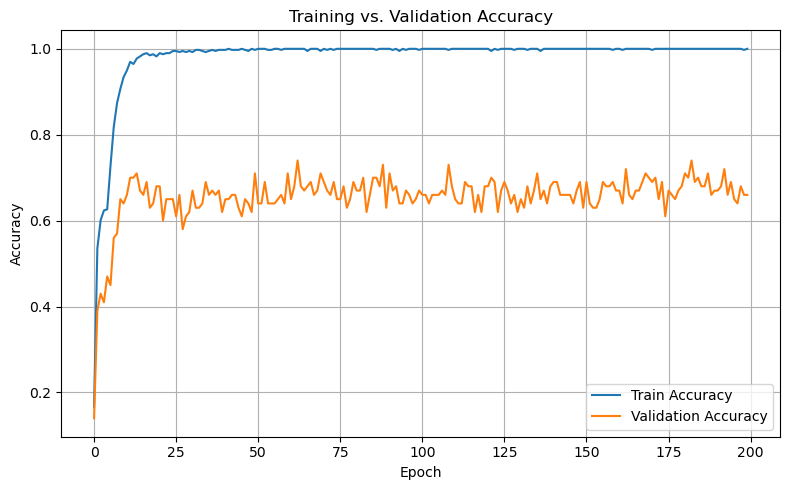

IndexError: index 2051 is out of bounds for axis 0 with size 496

In [1]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from torch_geometric.utils import from_scipy_sparse_matrix
import scipy.sparse as sp
import json

# =========================
# 1. Load and Preprocess Data
# =========================

adj = sp.load_npz('data/data/adj.npz')
feat = np.load('data/data/features.npy')
labels = np.load('data/data/labels.npy')
splits = json.load(open('data/data/splits.json'))
idx_train, idx_test = splits['idx_train'], splits['idx_test']

x = torch.from_numpy(feat).float()
y = torch.full((x.shape[0],), -1, dtype=torch.long)
y[idx_train] = torch.from_numpy(labels).long()

idx_train = torch.tensor(idx_train, dtype=torch.long)
idx_test = torch.tensor(idx_test, dtype=torch.long)
idx_train = idx_train[y[idx_train] != -1]

# Force CPU
device = torch.device('cpu')
x, y = x.to(device), y.to(device)
train_idx, val_idx = train_test_split(idx_train.numpy(), test_size=0.2, random_state=42)
train_idx = torch.tensor(train_idx, dtype=torch.long)
val_idx = torch.tensor(val_idx, dtype=torch.long)

# =========================
# 2. Define MLP Model
# =========================

class MLP(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc2(x)
        return x

# =========================
# 3. Train MLP
# =========================

num_features = x.shape[1]
num_classes = y[train_idx].max().item() + 1

model = MLP(num_features, 64, num_classes, dropout=0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

train_accuracies = []
val_accuracies = []

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(x)
    loss = criterion(out[train_idx], y[train_idx])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        _, pred = out.max(dim=1)
        train_acc = (pred[train_idx] == y[train_idx]).float().mean().item()
        val_acc = (pred[val_idx] == y[val_idx]).float().mean().item()
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

# =========================
# 4. Plot Accuracy
# =========================

plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =========================
# 5. Final Test Performance
# =========================

model.eval()
with torch.no_grad():
    out = model(x)
    pred = out.argmax(dim=1).cpu().numpy()

true_test_labels = labels[idx_test.numpy()]
pred_test_labels = pred[idx_test.numpy()]

acc = accuracy_score(true_test_labels, pred_test_labels)
prec = precision_score(true_test_labels, pred_test_labels, average='weighted', zero_division=0)
rec = recall_score(true_test_labels, pred_test_labels, average='weighted', zero_division=0)
f1 = f1_score(true_test_labels, pred_test_labels, average='weighted', zero_division=0)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall: {rec:.4f}")
print(f"Test F1-Score: {f1:.4f}")

# =========================
# 6. Confusion Matrix
# =========================

cm = confusion_matrix(true_test_labels, pred_test_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()


## GAT

Epoch 0: Train Acc=0.1515, Val Acc=0.1700
Epoch 10: Train Acc=0.6717, Val Acc=0.6700
Epoch 20: Train Acc=0.7096, Val Acc=0.6400
Epoch 30: Train Acc=0.7879, Val Acc=0.6900
Epoch 40: Train Acc=0.7601, Val Acc=0.7400
Epoch 50: Train Acc=0.7298, Val Acc=0.7200
Epoch 60: Train Acc=0.8207, Val Acc=0.7900
Epoch 70: Train Acc=0.8333, Val Acc=0.6900
Epoch 80: Train Acc=0.8131, Val Acc=0.7600
Epoch 90: Train Acc=0.8308, Val Acc=0.7600
Epoch 100: Train Acc=0.8207, Val Acc=0.7200
Epoch 110: Train Acc=0.8485, Val Acc=0.7400
Epoch 120: Train Acc=0.8232, Val Acc=0.7000
Epoch 130: Train Acc=0.8232, Val Acc=0.7300
Epoch 140: Train Acc=0.8561, Val Acc=0.7200
Epoch 150: Train Acc=0.8030, Val Acc=0.7400
Epoch 160: Train Acc=0.8182, Val Acc=0.7500
Epoch 170: Train Acc=0.8131, Val Acc=0.6800
Epoch 180: Train Acc=0.8005, Val Acc=0.7100
Epoch 190: Train Acc=0.7980, Val Acc=0.7500


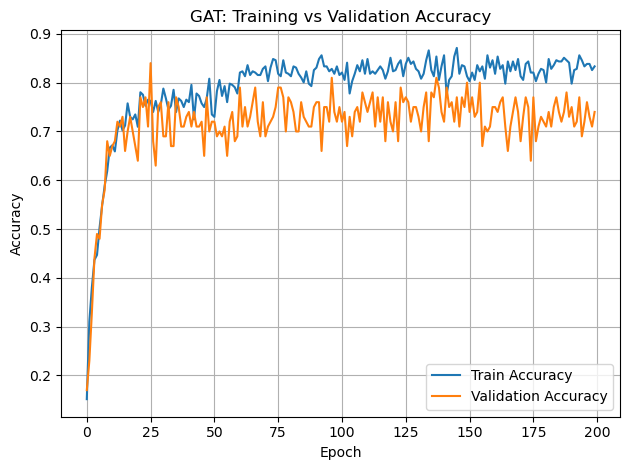


Best Validation Accuracy: 0.8400
Precision: 0.8552
Recall:    0.8400
F1 Score:  0.8410


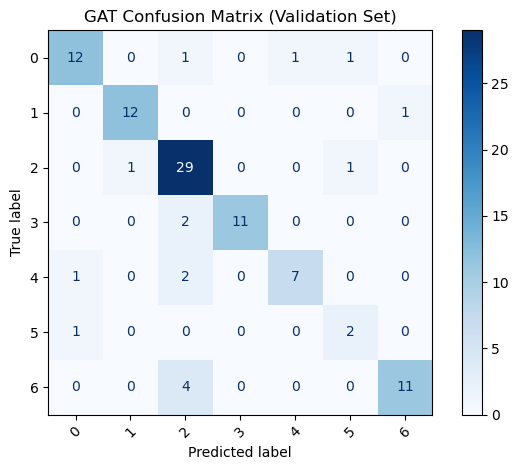

In [3]:
import os
import json
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv
from torch_geometric.utils import from_scipy_sparse_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# =========================
# 1. Load and Preprocess Data
# =========================

adj = sp.load_npz('data/data/adj.npz')
feat = np.load('data/data/features.npy')
labels = np.load('data/data/labels.npy')
splits = json.load(open('data/data/splits.json'))
idx_train, idx_test = splits['idx_train'], splits['idx_test']

x = torch.from_numpy(feat).float()
edge_index, _ = from_scipy_sparse_matrix(adj)

y = torch.full((x.shape[0],), -1, dtype=torch.long)
y[idx_train] = torch.from_numpy(labels).long()

idx_train = torch.tensor(idx_train, dtype=torch.long)
idx_test = torch.tensor(idx_test, dtype=torch.long)
idx_train = idx_train[y[idx_train] != -1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x, y, edge_index = x.to(device), y.to(device), edge_index.to(device)

# 80/20 split from training
train_idx, val_idx = train_test_split(idx_train.cpu().numpy(), test_size=0.2, random_state=42)
train_idx = torch.tensor(train_idx, dtype=torch.long, device=device)
val_idx = torch.tensor(val_idx, dtype=torch.long, device=device)

# =========================
# 2. Define GAT Model
# =========================

class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.6):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat2(x, edge_index)
        return x

# =========================
# 3. Train and Evaluate
# =========================

num_features = x.shape[1]
num_classes = y[train_idx].max().item() + 1

model = GAT(num_features, hidden_channels=8, out_channels=num_classes, heads=8, dropout=0.6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

train_accuracies = []
val_accuracies = []
best_val_acc = 0
best_pred = None

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index)
    loss = criterion(out[train_idx], y[train_idx])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        _, pred = out.max(dim=1)
        train_acc = (pred[train_idx] == y[train_idx]).float().mean().item()
        val_acc = (pred[val_idx] == y[val_idx]).float().mean().item()
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_pred = pred.clone().cpu().numpy()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

# =========================
# 4. Accuracy Plot
# =========================

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('GAT: Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("gat_accuracy_plot.png")
plt.show()

# =========================
# 5. Final Evaluation
# =========================

true_labels = y[val_idx].cpu().numpy()
pred_labels = best_pred[val_idx.cpu().numpy()]

precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)

print("\nBest Validation Accuracy:", f"{best_val_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# =========================
# 6. Confusion Matrix
# =========================

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("GAT Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.savefig("gat_confusion_matrix.png")
plt.show()


Epoch 0: Train Acc=0.2096, Val Acc=0.1500
Epoch 10: Train Acc=0.9318, Val Acc=0.8700
Epoch 20: Train Acc=0.9773, Val Acc=0.8200
Epoch 30: Train Acc=0.9874, Val Acc=0.8600
Epoch 40: Train Acc=1.0000, Val Acc=0.8500
Epoch 50: Train Acc=0.9975, Val Acc=0.8400
Epoch 60: Train Acc=1.0000, Val Acc=0.8300
Epoch 70: Train Acc=1.0000, Val Acc=0.8600
Epoch 80: Train Acc=1.0000, Val Acc=0.8100
Epoch 90: Train Acc=1.0000, Val Acc=0.8300
Epoch 100: Train Acc=0.9975, Val Acc=0.8700
Epoch 110: Train Acc=1.0000, Val Acc=0.8400
Epoch 120: Train Acc=1.0000, Val Acc=0.8500
Epoch 130: Train Acc=1.0000, Val Acc=0.8400
Epoch 140: Train Acc=0.9975, Val Acc=0.8500
Epoch 150: Train Acc=1.0000, Val Acc=0.8600
Epoch 160: Train Acc=1.0000, Val Acc=0.8500
Epoch 170: Train Acc=0.9975, Val Acc=0.8600
Epoch 180: Train Acc=1.0000, Val Acc=0.8400
Epoch 190: Train Acc=1.0000, Val Acc=0.8600


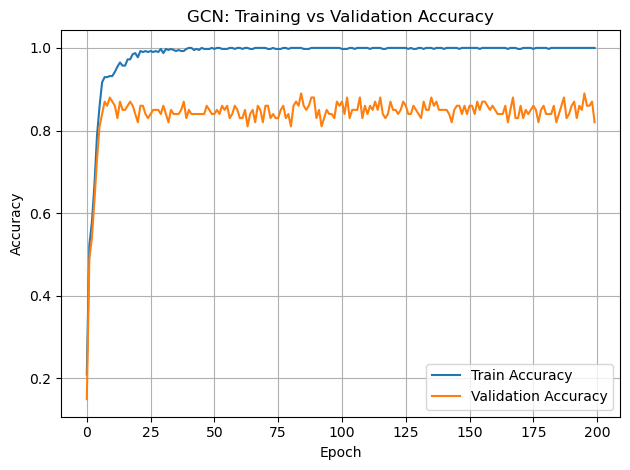


Best Validation Accuracy: 0.8900
Precision: 0.8929
Recall:    0.8900
F1 Score:  0.8896


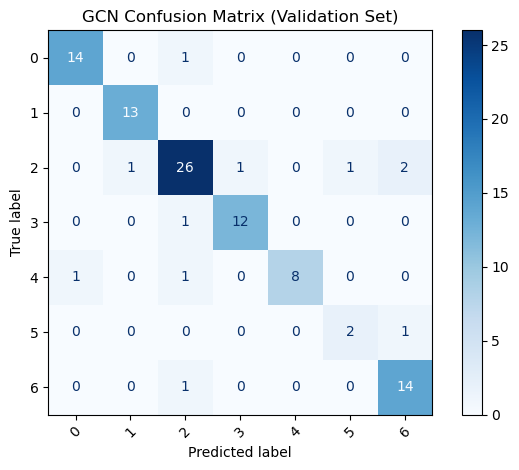

In [4]:
import os
import json
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_scipy_sparse_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# =========================
# 1. Load and Preprocess Data
# =========================

adj = sp.load_npz('data/data/adj.npz')
feat = np.load('data/data/features.npy')
labels = np.load('data/data/labels.npy')
splits = json.load(open('data/data/splits.json'))
idx_train, idx_test = splits['idx_train'], splits['idx_test']

x = torch.from_numpy(feat).float()
edge_index, _ = from_scipy_sparse_matrix(adj)

y = torch.full((x.shape[0],), -1, dtype=torch.long)
y[idx_train] = torch.from_numpy(labels).long()

idx_train = torch.tensor(idx_train, dtype=torch.long)
idx_test = torch.tensor(idx_test, dtype=torch.long)
idx_train = idx_train[y[idx_train] != -1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x, y, edge_index = x.to(device), y.to(device), edge_index.to(device)

# 80/20 split from training
train_idx, val_idx = train_test_split(idx_train.cpu().numpy(), test_size=0.2, random_state=42)
train_idx = torch.tensor(train_idx, dtype=torch.long, device=device)
val_idx = torch.tensor(val_idx, dtype=torch.long, device=device)

# =========================
# 2. Define GCN Model
# =========================

class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# =========================
# 3. Train and Evaluate
# =========================

num_features = x.shape[1]
num_classes = y[train_idx].max().item() + 1

model = GCN(num_features, hidden_channels=64, out_channels=num_classes, dropout=0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

train_accuracies = []
val_accuracies = []
best_val_acc = 0
best_pred = None

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index)
    loss = criterion(out[train_idx], y[train_idx])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        _, pred = out.max(dim=1)
        train_acc = (pred[train_idx] == y[train_idx]).float().mean().item()
        val_acc = (pred[val_idx] == y[val_idx]).float().mean().item()
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_pred = pred.clone().cpu().numpy()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

# =========================
# 4. Accuracy Plot
# =========================

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('GCN: Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("gcn_accuracy_plot.png")
plt.show()

# =========================
# 5. Final Evaluation
# =========================

true_labels = y[val_idx].cpu().numpy()
pred_labels = best_pred[val_idx.cpu().numpy()]

precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)

print("\nBest Validation Accuracy:", f"{best_val_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# =========================
# 6. Confusion Matrix
# =========================

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("GCN Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.savefig("gcn_confusion_matrix.png")
plt.show()


Epoch 0: Train Acc=0.1338, Val Acc=0.1400
Epoch 10: Train Acc=0.9924, Val Acc=0.8400
Epoch 20: Train Acc=0.9975, Val Acc=0.7800
Epoch 30: Train Acc=1.0000, Val Acc=0.8100
Epoch 40: Train Acc=1.0000, Val Acc=0.8500
Epoch 50: Train Acc=1.0000, Val Acc=0.8400
Epoch 60: Train Acc=1.0000, Val Acc=0.8300
Epoch 70: Train Acc=1.0000, Val Acc=0.8300
Epoch 80: Train Acc=1.0000, Val Acc=0.8300
Epoch 90: Train Acc=1.0000, Val Acc=0.8200
Epoch 100: Train Acc=0.9975, Val Acc=0.8600
Epoch 110: Train Acc=1.0000, Val Acc=0.8400
Epoch 120: Train Acc=1.0000, Val Acc=0.8500
Epoch 130: Train Acc=1.0000, Val Acc=0.8500
Epoch 140: Train Acc=1.0000, Val Acc=0.8400
Epoch 150: Train Acc=1.0000, Val Acc=0.8300
Epoch 160: Train Acc=1.0000, Val Acc=0.8200
Epoch 170: Train Acc=1.0000, Val Acc=0.8700
Epoch 180: Train Acc=1.0000, Val Acc=0.8300
Epoch 190: Train Acc=1.0000, Val Acc=0.8400


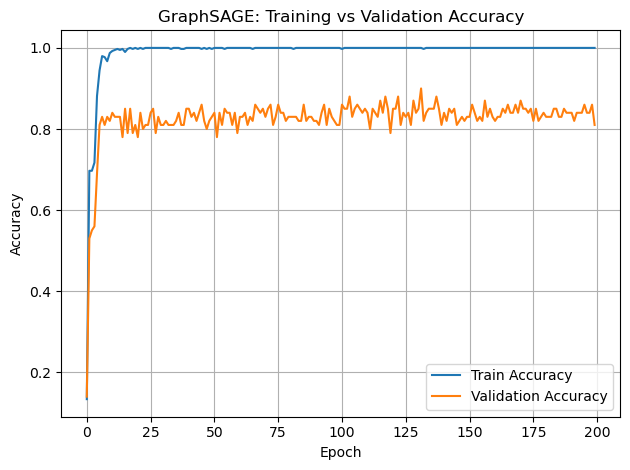


Best Validation Accuracy: 0.9000
Precision: 0.9013
Recall:    0.9000
F1 Score:  0.8994


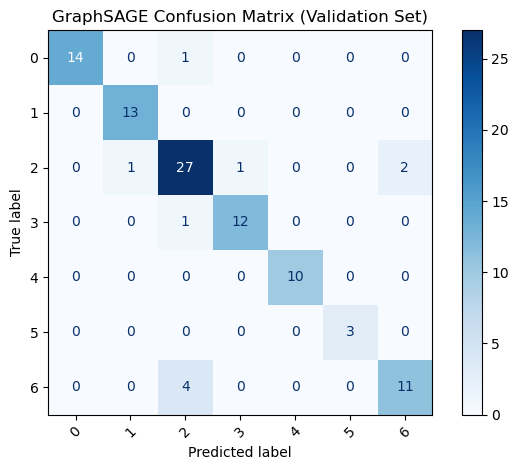

In [5]:
import os
import json
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import from_scipy_sparse_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# =========================
# 1. Load and Preprocess Data
# =========================

adj = sp.load_npz('data/data/adj.npz')
feat = np.load('data/data/features.npy')
labels = np.load('data/data/labels.npy')
splits = json.load(open('data/data/splits.json'))
idx_train, idx_test = splits['idx_train'], splits['idx_test']

x = torch.from_numpy(feat).float()
edge_index, _ = from_scipy_sparse_matrix(adj)

y = torch.full((x.shape[0],), -1, dtype=torch.long)
y[idx_train] = torch.from_numpy(labels).long()

idx_train = torch.tensor(idx_train, dtype=torch.long)
idx_test = torch.tensor(idx_test, dtype=torch.long)
idx_train = idx_train[y[idx_train] != -1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x, y, edge_index = x.to(device), y.to(device), edge_index.to(device)

# 80/20 split from training
train_idx, val_idx = train_test_split(idx_train.cpu().numpy(), test_size=0.2, random_state=42)
train_idx = torch.tensor(train_idx, dtype=torch.long, device=device)
val_idx = torch.tensor(val_idx, dtype=torch.long, device=device)

# =========================
# 2. Define GraphSAGE Model
# =========================

class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.sage1 = SAGEConv(in_channels, hidden_channels)
        self.sage2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.sage1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.sage2(x, edge_index)
        return x

# =========================
# 3. Train and Evaluate
# =========================

num_features = x.shape[1]
num_classes = y[train_idx].max().item() + 1

model = GraphSAGE(num_features, hidden_channels=64, out_channels=num_classes, dropout=0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

train_accuracies = []
val_accuracies = []
best_val_acc = 0
best_pred = None

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index)
    loss = criterion(out[train_idx], y[train_idx])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        _, pred = out.max(dim=1)
        train_acc = (pred[train_idx] == y[train_idx]).float().mean().item()
        val_acc = (pred[val_idx] == y[val_idx]).float().mean().item()
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_pred = pred.clone().cpu().numpy()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

# =========================
# 4. Accuracy Plot
# =========================

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('GraphSAGE: Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("graphsage_accuracy_plot.png")
plt.show()

# =========================
# 5. Final Evaluation
# =========================

true_labels = y[val_idx].cpu().numpy()
pred_labels = best_pred[val_idx.cpu().numpy()]

precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)

print("\nBest Validation Accuracy:", f"{best_val_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# =========================
# 6. Confusion Matrix
# =========================

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("GraphSAGE Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.savefig("graphsage_confusion_matrix.png")
plt.show()


Epoch 0: Train Acc=0.1389, Val Acc=0.1800
Epoch 10: Train Acc=0.9318, Val Acc=0.6200
Epoch 20: Train Acc=0.9848, Val Acc=0.6300
Epoch 30: Train Acc=0.9949, Val Acc=0.6600
Epoch 40: Train Acc=1.0000, Val Acc=0.6200
Epoch 50: Train Acc=0.9975, Val Acc=0.6900
Epoch 60: Train Acc=1.0000, Val Acc=0.6800
Epoch 70: Train Acc=1.0000, Val Acc=0.6600
Epoch 80: Train Acc=1.0000, Val Acc=0.6600
Epoch 90: Train Acc=1.0000, Val Acc=0.6700
Epoch 100: Train Acc=1.0000, Val Acc=0.6800
Epoch 110: Train Acc=1.0000, Val Acc=0.6700
Epoch 120: Train Acc=1.0000, Val Acc=0.6700
Epoch 130: Train Acc=1.0000, Val Acc=0.6800
Epoch 140: Train Acc=1.0000, Val Acc=0.7200
Epoch 150: Train Acc=1.0000, Val Acc=0.7000
Epoch 160: Train Acc=1.0000, Val Acc=0.6600
Epoch 170: Train Acc=1.0000, Val Acc=0.6600
Epoch 180: Train Acc=1.0000, Val Acc=0.6800
Epoch 190: Train Acc=1.0000, Val Acc=0.7300


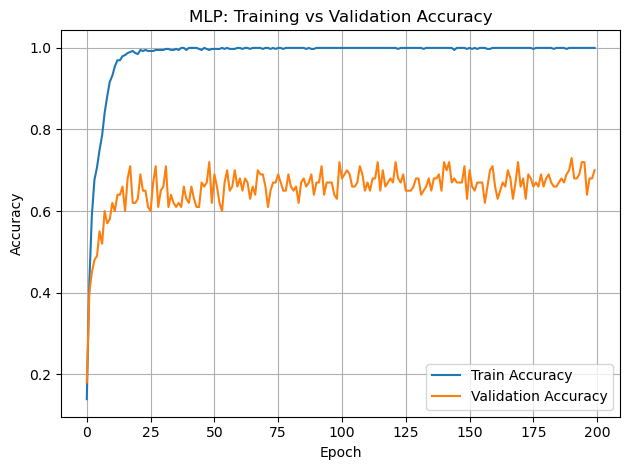


Best Validation Accuracy: 0.7300
Precision: 0.7436
Recall:    0.7300
F1 Score:  0.7319


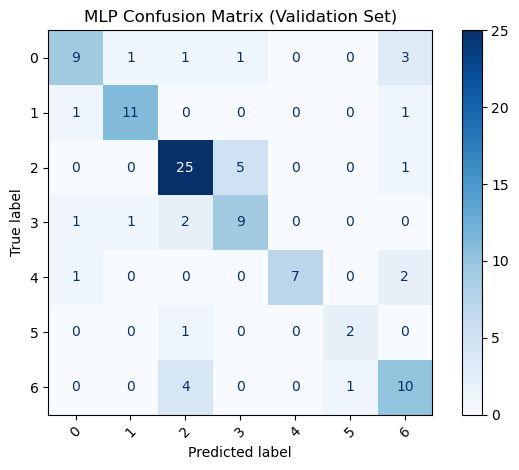

In [6]:
import os
import json
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# =========================
# 1. Load and Preprocess Data
# =========================

adj = sp.load_npz('data/data/adj.npz')
feat = np.load('data/data/features.npy')
labels = np.load('data/data/labels.npy')
splits = json.load(open('data/data/splits.json'))
idx_train, idx_test = splits['idx_train'], splits['idx_test']

x = torch.from_numpy(feat).float()
y = torch.full((x.shape[0],), -1, dtype=torch.long)
y[idx_train] = torch.from_numpy(labels).long()

idx_train = torch.tensor(idx_train, dtype=torch.long)
idx_test = torch.tensor(idx_test, dtype=torch.long)
idx_train = idx_train[y[idx_train] != -1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x, y = x.to(device), y.to(device)

# 80/20 split from training
train_idx, val_idx = train_test_split(idx_train.cpu().numpy(), test_size=0.2, random_state=42)
train_idx = torch.tensor(train_idx, dtype=torch.long, device=device)
val_idx = torch.tensor(val_idx, dtype=torch.long, device=device)

# =========================
# 2. Define MLP Model
# =========================

class MLP(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc2(x)
        return x

# =========================
# 3. Train and Evaluate
# =========================

num_features = x.shape[1]
num_classes = y[train_idx].max().item() + 1

model = MLP(num_features, hidden_channels=64, out_channels=num_classes, dropout=0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

train_accuracies = []
val_accuracies = []
best_val_acc = 0
best_pred = None

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(x)
    loss = criterion(out[train_idx], y[train_idx])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        _, pred = out.max(dim=1)
        train_acc = (pred[train_idx] == y[train_idx]).float().mean().item()
        val_acc = (pred[val_idx] == y[val_idx]).float().mean().item()
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_pred = pred.clone().cpu().numpy()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

# =========================
# 4. Accuracy Plot
# =========================

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MLP: Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("mlp_accuracy_plot.png")
plt.show()

# =========================
# 5. Final Evaluation
# =========================

true_labels = y[val_idx].cpu().numpy()
pred_labels = best_pred[val_idx.cpu().numpy()]

precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)

print("\nBest Validation Accuracy:", f"{best_val_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# =========================
# 6. Confusion Matrix
# =========================

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("MLP Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.savefig("mlp_confusion_matrix.png")
plt.show()
